In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import json

with open('/content/drive/MyDrive/kaggle.json', 'r') as f:
    kaggle_credentials = json.load(f)

!mkdir ~/.kaggle
with open('/root/.kaggle/kaggle.json', 'w') as f:
    json.dump(kaggle_credentials, f)

!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c dogs-vs-cats

 99% 802M/812M [00:03<00:00, 252MB/s]
100% 812M/812M [00:03<00:00, 249MB/s]


In [ ]:
!unzip dogs-vs-cats.zip

Archive:  dogs-vs-cats.zip
  inflating: sampleSubmission.csv    
  inflating: test1.zip               
  inflating: train.zip               


In [ ]:
!unzip train.zip
!unzip test1.zip

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_dir = '/content/train'
test_dir = '/content/test1'
img_size = 150
batch_size = 32

In [ ]:
from glob import glob
import os

file_names = glob('/content/train/*.jpg')
categories = [1 if 'dog' in pic else 0 for pic in os.listdir("/content/train")]

df = pd.DataFrame({'filename': file_names, 'category':categories})
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'})

print("shape:", df.shape)
df.head()

shape: (25000, 2)


,filename,category
0,/content/train/cat.7673.jpg,cat
1,/content/train/dog.2997.jpg,dog
2,/content/train/dog.11520.jpg,dog
3,/content/train/dog.4568.jpg,dog
4,/content/train/cat.8025.jpg,cat


In [ ]:
from sklearn.model_selection import train_test_split

train_df, validate_df = train_test_split(df, test_size=0.2, random_state=10)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

# print shape
train_df.shape, validate_df.shape

((20000, 2), (5000, 2))

In [ ]:
file_names = glob('/content/test1/*.jpg')
categories = [1 if 'dog' in pic else 0 for pic in os.listdir("/content/test1")]

test_df = pd.DataFrame({'filename': file_names, 'category':categories})
test_df["category"] = df["category"].replace({0: 'cat', 1: 'dog'})

test_df.head()

test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory="/content/test1",
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size= (img_size, img_size),
    batch_size= batch_size
)

Found 12500 validated image filenames belonging to 2 classes.


In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
)
train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'filename',
    y_col = 'category',
    target_size = (img_size, img_size),
    batch_size = batch_size,
    class_mode = 'binary',
)
validation_generator = train_datagen.flow_from_dataframe(
    dataframe = validate_df,
    x_col = 'filename',
    y_col = 'category',
    target_size = (img_size, img_size),
    batch_size = batch_size,
    class_mode = 'binary',
)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.
Found 12500 validated image filenames.


In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(img_size, img_size, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

In [ ]:
model.compile(loss = 'binary_crossentropy',
              optimizer = tf.keras.optimizers.legacy.RMSprop(learning_rate = 1e-4),
              metrics = ['acc'])
history = model.fit(
    train_generator, 
    steps_per_epoch = train_generator.samples//train_generator.batch_size,
    epochs = 1,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples//validation_generator.batch_size
)

625/625 [==============================] - 192s 307ms/step - loss: 0.3208 - acc: 0.8589 - val_loss: 0.3410 - val_acc: 0.8472


In [ ]:
test_loss, test_acc = model.evaluate(test_generator)

print('test accuracy:', test_acc)

391/391 [==============================] - 40s 103ms/step - loss: 1.6634 - acc: 0.5082
test accuracy: 0.5082399845123291


391/391 [==============================] - 38s 97ms/step


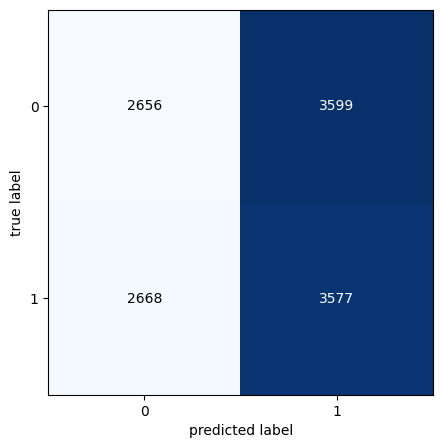

In [ ]:
import sklearn
from mlxtend.plotting import plot_confusion_matrix
test_generator.reset()
y_pred = model.predict(test_generator)
y_pred_classes = np.round(y_pred)
cm = sklearn.metrics.confusion_matrix(test_generator.classes, y_pred_classes)
fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(5,5))
plt.show()

In [ ]:
print(sklearn.metrics.classification_report(test_generator.classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.50      0.42      0.46      6255
           1       0.50      0.57      0.53      6245

    accuracy                           0.50     12500
   macro avg       0.50      0.50      0.50     12500
weighted avg       0.50      0.50      0.50     12500

